## import hubs and cell scores

In [1]:
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
import os


from matplotlib.pyplot import rc_context

import gseapy as gp



with open('../data/files/5_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/5_TMS_HUBS_METADATA_FILTERED.pickle')


with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

gene_set = {'senescence':list(markers)} #for enrichr

hubs_enr = {k[0] + ' ' + k[1] + ' ' + str(k[2]): [x[0] for x in v] for (k,v) in hubs.items()} #for enrichr

In [2]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [3]:
df = pd.read_pickle('../data/files/7_TMS_HUB_SCORES_FILTERED_v1.pickle')
adata.obsm['hub_scores'] = df

tissue_cells = adata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})
tissue_cells = tissue_cells[tissue_cells.Count > 0]


/tmp/ipykernel_1478985/133023798.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tissue_cells = adata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})


In [4]:
def find_outliers(scores, mult = 3):
    sd = scores.std()
    mu = scores.mean()
    
    thresh = mu + mult*sd
    
    return scores > thresh
    
    
big_out = []

#may want to add filter so that x number of cells in aged organism exists, or can just filter later...
for tissue, cell in tqdm(tissue_cells[tissue_cells.columns[0:2]].values):
    #print(tissue, cell)

    sub = adata[(adata.obs.tissue2 == tissue) & (adata.obs.cell_type_2 == cell)]
    #sub.obs = pd.concat((sub.obs,sub.obsm['hub_scores']), axis = 1) #recombine just to make easier to filter/plot etc

    out = []
    for hub in sub.obsm['hub_scores'].columns:

        #sd = sub.obsm['hub_scores'][hub].std()
        #mu = sub.obsm['hub_scores'][hub].mean()

        out.append(find_outliers(sub.obsm['hub_scores'][hub]))

      
    big_out.append(pd.concat(out, axis = 1))    


100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 12.36it/s]


In [5]:
adata.obsm['sen_outlier'] = pd.concat(big_out).reindex(adata.obs.index)
adata.obsm['sen_outlier']

,Bladder__bladder cell__0,Bladder__bladder cell__1,Bladder__bladder cell__2,Bladder__endothelial cell__1,Diaphragm__mesenchymal stem cell__0,Diaphragm__mesenchymal stem cell__2,Diaphragm__skeletal muscle satellite cell__0,Diaphragm__skeletal muscle satellite cell__1,Fat__endothelial cell__0,Fat__mesenchymal stem cell__0,...,Tongue__basal cell __0,Tongue__basal cell __1,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Trachea__basal cell __0,Trachea__basal cell __1,Trachea__fibroblast__0,Trachea__fibroblast__1,Trachea__macrophage__0,Trachea__macrophage__1
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACCTGCAGTAAGCG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACCTGTCATTATCC-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACGGGGTACAGTGG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACGGGGTCTTCTCG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P9.MAA001883.3_39_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P9.MAA001887.3_39_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# kinetics/characterstics of multi-hub examples

## toungue keratinocyte

In [6]:
hub_metadata[(hub_metadata.tissue == 'Tongue') & (hub_metadata.cell == 'keratinocyte')]

,tissue,cell,hub_num,size,n_sen,hyp
67,Tongue,keratinocyte,0,133,14,2.068164e-11
68,Tongue,keratinocyte,1,86,5,1.160686e-03


In [7]:
sdata = adata[(adata.obs.cell_type_2 == 'keratinocyte') & (adata.obs.tissue2 == 'Tongue')]

In [8]:
sdata.obs['Tongue__keratinocyte__0'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__0']*1
sdata.obs['Tongue__keratinocyte__1'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__1']*1


sdata.obs['Tongue__keratinocyte__0_s'] = sdata.obsm['hub_scores']['Tongue__keratinocyte__0']
sdata.obs['Tongue__keratinocyte__1_s'] = sdata.obsm['hub_scores']['Tongue__keratinocyte__1']

/tmp/ipykernel_1852208/706448531.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.obs['Tongue__keratinocyte__0'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__0']*1


In [9]:
df = sdata.obs[['age', 'Tongue__keratinocyte__0',
           'Tongue__keratinocyte__1']].groupby('age').sum()
df

/tmp/ipykernel_1852208/2790731406.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = sdata.obs[['age', 'Tongue__keratinocyte__0',


,Tongue__keratinocyte__0,Tongue__keratinocyte__1
age,,
1m,0,15
3m,2,8
18m,2,26
24m,170,252


In [10]:
sdata.obs.groupby('age').count().batch #make sure index in same order

/tmp/ipykernel_1852208/3249192661.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sdata.obs.groupby('age').count().batch #make sure index in same order


age
1m     2711
3m     3884
18m    2118
24m    3622
Name: batch, dtype: int64

In [11]:
df['Count'] = sdata.obs.groupby('age').count().batch #make sure index in same order

/tmp/ipykernel_1852208/4125562115.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Count'] = sdata.obs.groupby('age').count().batch #make sure index in same order


In [12]:
df['hub 0'] = df.Tongue__keratinocyte__0 / df.Count * 100
df['hub 1'] = df.Tongue__keratinocyte__1 / df.Count * 100

In [13]:
df

,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Count,hub 0,hub 1
age,,,,,
1m,0,15,2711,0.000000,0.553301
3m,2,8,3884,0.051493,0.205973
18m,2,26,2118,0.094429,1.227573
24m,170,252,3622,4.693539,6.957482


In [14]:
df2 = sdata.obs.melt(id_vars = 'age', value_vars = ['Tongue__keratinocyte__0_s', 'Tongue__keratinocyte__1_s'])
df2

,age,variable,value
0,24m,Tongue__keratinocyte__0_s,1.616820
1,24m,Tongue__keratinocyte__0_s,0.512392
2,24m,Tongue__keratinocyte__0_s,-0.360624
3,24m,Tongue__keratinocyte__0_s,-0.444444
4,24m,Tongue__keratinocyte__0_s,2.358118
...,...,...,...
24665,3m,Tongue__keratinocyte__1_s,6.339346
24666,3m,Tongue__keratinocyte__1_s,2.253698
24667,3m,Tongue__keratinocyte__1_s,2.553090
24668,3m,Tongue__keratinocyte__1_s,0.601152


In [15]:
df['age'] = df.index
df

,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Count,hub 0,hub 1,age
age,,,,,,
1m,0,15,2711,0.000000,0.553301,1m
3m,2,8,3884,0.051493,0.205973,3m
18m,2,26,2118,0.094429,1.227573,18m
24m,170,252,3622,4.693539,6.957482,24m


In [16]:
df = df.melt(id_vars = 'age', value_vars=['hub 0', 'hub 1'])
df

,age,variable,value
0,1m,hub 0,0.000000
1,3m,hub 0,0.051493
2,18m,hub 0,0.094429
3,24m,hub 0,4.693539
4,1m,hub 1,0.553301
5,3m,hub 1,0.205973
6,18m,hub 1,1.227573
7,24m,hub 1,6.957482


In [17]:
df.age = df.age.map(lambda x: int(x.replace('m', ''))).astype('int')

In [75]:
#df2.age = df2.age.map(lambda x: int(x.replace('m', ''))).astype('int')

### Fig 3F

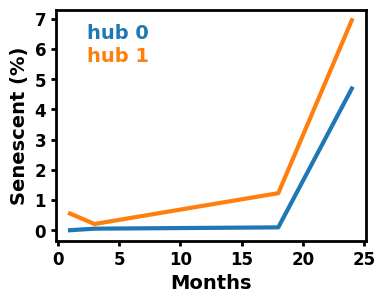

In [19]:
plt.figure(figsize = (4,3))

ax = sns.lineplot(data = df, x = 'age', y = 'value', hue = 'variable', lw = 3)


for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescent (%)', size = 14, weight = 'bold')

plt.xlabel('Months', size = 14, weight = 'bold')

plt.legend([],[], frameon=False)

plt.text(s = 'hub 0', x = 0.1, y = 0.9, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:blue')

plt.text(s = 'hub 1', x = 0.1, y = 0.8, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:orange')


plt.savefig('figures/3F.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3F.svg', bbox_inches = 'tight')

plt.show()

### Fig 3E

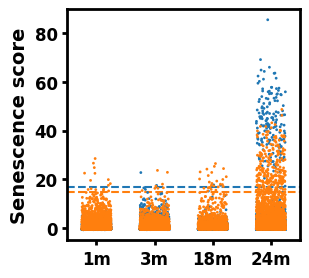

In [20]:
plt.figure(figsize = (3,3))


ax = sns.stripplot(data = df2, x = 'age', y = 'value', hue = 'variable',
              s = 2, jitter = .25)

plt.legend([],[], frameon=False)



ax.axhline(df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.std(),
           c = 'tab:blue', zorder = 0, ls = '--', lw = 1.5)


ax.axhline(df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.std(), 
          c = 'tab:orange', zorder = 0, ls = '--', lw = 1.5)




for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold' ) #rotation = 35, rotation_mode = 'anchor', ha = 'right'
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescence score', size = 14, weight = 'bold')

plt.xlabel('')

plt.savefig('figures/3E.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3E.svg', bbox_inches = 'tight')


plt.show()

In [21]:
test = hubs[('Tongue','keratinocyte',0)]
test = [x[0] for x in test]

enr = gp.enrichr(gene_list= test,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )

res1 = enr.results
res1['hub'] = 0

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


In [22]:
test = hubs[('Tongue','keratinocyte',1)]
test = [x[0] for x in test]

enr = gp.enrichr(gene_list= test,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )

res = enr.results
res['hub'] = 1

In [23]:
res = pd.concat((res1, res))

In [33]:
len(res.loc[968].Genes.split(';'))

6

In [34]:
res = res[res['Adjusted P-value'] < 0.05]

res['nlog10'] = -np.log10(res['Adjusted P-value'])

res['num'] = res.Genes.map(lambda x: len(x.split(';')))

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


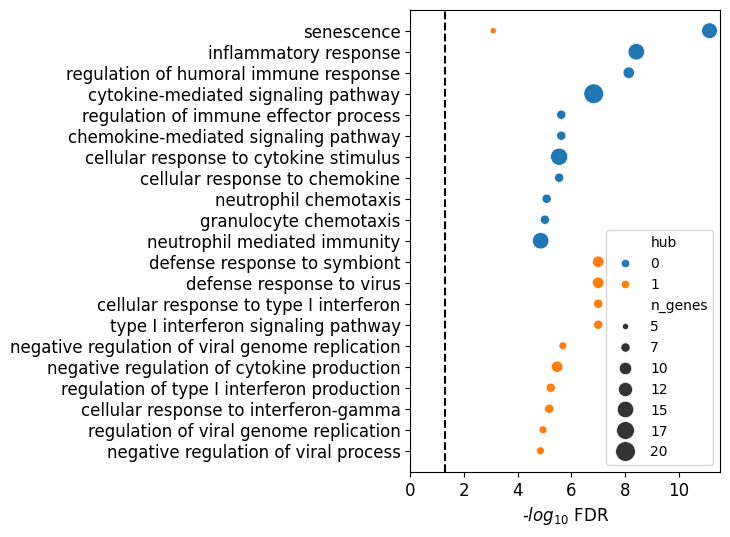

In [41]:
go10 = pd.concat((res[(res.hub == 0) &\
                      (res.Gene_set.str.startswith('GO'))].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 res[(res.hub == 1) &\
                      (res.Gene_set.str.startswith('GO'))].nsmallest(n = 10, columns = 'Adjusted P-value')))

go10['Term'] = go10['Term'].map(lambda x: x.split(' (')[0])

go10 = pd.concat((go10, res[res.Term == 'senescence']))

go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])


go10 = go10.rename(columns = {'num': 'n_genes'})


plt.figure(figsize = (4,6))
sns.scatterplot(data = go10, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')


plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/3B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3B.svg', bbox_inches = 'tight')

plt.show()

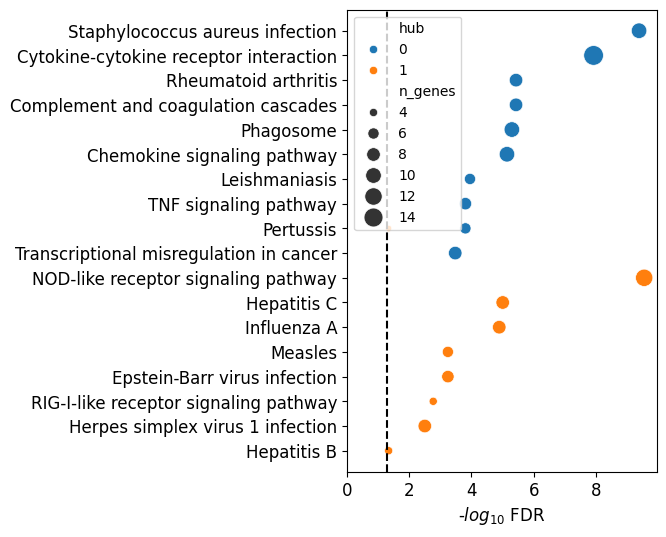

In [45]:
go10 = pd.concat((res[(res.hub == 0) &\
                      (res.Gene_set.str.startswith('KEGG'))].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 res[(res.hub == 1) &\
                      (res.Gene_set.str.startswith('KEGG'))].nsmallest(n = 10, columns = 'Adjusted P-value')))


plt.figure(figsize = (4,6))

go10 = go10.rename(columns = {'num': 'n_genes'})

sns.scatterplot(data = go10, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')

plt.legend(loc='upper left')


plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/3C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3C.svg', bbox_inches = 'tight')


plt.show()

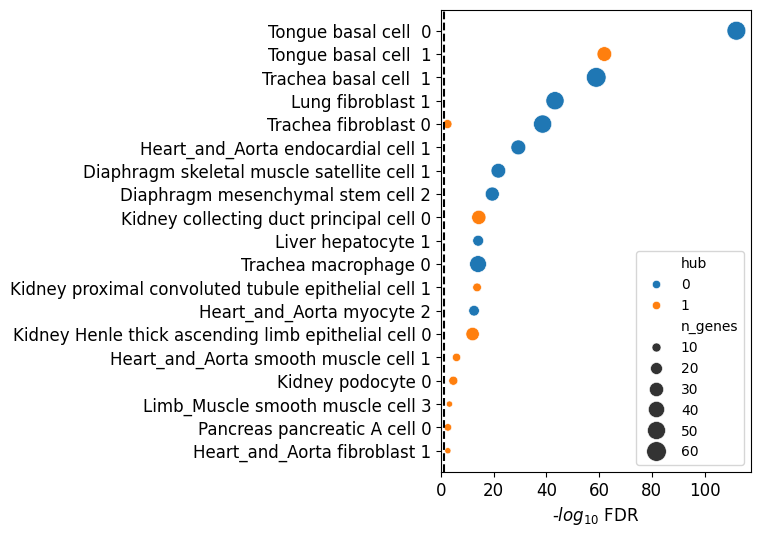

In [55]:
def remove_self_comparisons(x): #pass overlap, none are the same exact genes
    left, right = x.split('/')
    if left == right:
        return False
    else:
        return True


plotter = res[res.Gene_set.str.contains('gs_ind')]

plotter = plotter[plotter.Overlap.map(remove_self_comparisons)]

plotter = plotter[plotter['Adjusted P-value'] < 0.05]
plotter = plotter[plotter.Term != 'senescence']

plotter = pd.concat((plotter[(plotter.hub == 0)].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 plotter[(plotter.hub == 1)].nsmallest(n = 10, columns = 'Adjusted P-value')))


plotter = plotter.sort_values('Adjusted P-value')
plotter = plotter.rename(columns = {'num': 'n_genes'})



plt.figure(figsize = (4,6))
sns.scatterplot(data = plotter, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')

plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/3D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3D.svg', bbox_inches = 'tight')

plt.show()

## Fibroblast

In [56]:
meta_sub = hub_metadata[(hub_metadata.cell == 'fibroblast')]
meta_sub.reset_index(drop = True)

,tissue,cell,hub_num,size,n_sen,hyp
0,Heart_and_Aorta,fibroblast,0,61,5,2.382758e-04
1,Heart_and_Aorta,fibroblast,1,34,0,1.000000e+00
2,Lung,fibroblast,0,254,3,4.110577e-01
3,Lung,fibroblast,1,547,23,1.201959e-09
4,Trachea,fibroblast,0,680,21,1.173190e-06
5,Trachea,fibroblast,1,74,2,1.470802e-01


In [57]:
sdata = adata[(adata.obs.cell_type_2 == 'fibroblast') &
              (adata.obs.tissue2.isin(['Heart_and_Aorta', 'Lung', 'Trachea']))]


In [58]:
out = []
for y in range(len(meta_sub)):
    for age in ['1m', '3m', '18m', '21m', '24m', '30m']:
        
        tissue = meta_sub.iloc[y].tissue
        hub_num = meta_sub.iloc[y].hub_num
        
        
        subby = sdata[(sdata.obs.tissue2 == tissue) & (sdata.obs.age == age)]
        
        num_outliers = subby.obsm['sen_outlier'][tissue + '__fibroblast__' + str(hub_num)].sum()
        
        out.append([tissue, hub_num, age, len(subby), num_outliers])
        

In [59]:
df = pd.DataFrame(out, columns = ['tissue', 'hub', 'age', 'Count', 'value'])
df = df[df.Count > 75]
df['per'] = df.value /df.Count * 100

df.age = df.age.map(lambda x: int(x.replace('m', '')))

df

,tissue,hub,age,Count,value,per
0,Heart_and_Aorta,0,1,266,5,1.879699
1,Heart_and_Aorta,0,3,2419,4,0.165358
2,Heart_and_Aorta,0,18,1332,13,0.975976
3,Heart_and_Aorta,0,21,294,0,0.000000
4,Heart_and_Aorta,0,24,1063,50,4.703669
5,Heart_and_Aorta,0,30,1005,84,8.358209
6,Heart_and_Aorta,1,1,266,3,1.127820
7,Heart_and_Aorta,1,3,2419,20,0.826788
8,Heart_and_Aorta,1,18,1332,22,1.651652
9,Heart_and_Aorta,1,21,294,0,0.000000


In [60]:
#group these not on 1 and 0, but similarity?

In [4]:
fibos = {k:v for (k,v) in hubs.items() if k[0] in ['Heart_and_Aorta', 'Lung', 'Trachea'] and k[1] == 'fibroblast'}

#combos = list(itertools.combinations(list(fibos), 2))
combos = list(itertools.product(list(fibos), list(fibos))) #includes self comparison

In [5]:
#calculate "importance" of each gene to signature by the number of edges, normalize by total nodes

out = []
for combo in tqdm(combos):
    test1 = hubs[combo[0]]
    test2 = hubs[combo[1]]
    test1 = pd.DataFrame(test1)
    test1[1] = test1[1]/len(test1)
    test2 = pd.DataFrame(test2)
    test2[1] = test2[1]/len(test2)
    vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
    vals = vals.fillna(0)
    #result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    result = spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    out.append([combo[0][0] + '__'  + str(combo[0][2]),
                combo[1][0] + '__' + str(combo[1][2]), result])

100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 448.10it/s]


In [6]:
dists = pd.DataFrame(out, columns = ['h1', 'h2', 'distance'])
dists

,h1,h2,distance
0,Heart_and_Aorta__0,Heart_and_Aorta__0,0.000000
1,Heart_and_Aorta__0,Heart_and_Aorta__1,1.000000
2,Heart_and_Aorta__0,Lung__0,0.990315
3,Heart_and_Aorta__0,Lung__1,0.888853
4,Heart_and_Aorta__0,Trachea__0,0.947464
5,Heart_and_Aorta__0,Trachea__1,0.969027
6,Heart_and_Aorta__1,Heart_and_Aorta__0,1.000000
7,Heart_and_Aorta__1,Heart_and_Aorta__1,0.000000
8,Heart_and_Aorta__1,Lung__0,0.974783
9,Heart_and_Aorta__1,Lung__1,0.980064


In [7]:
dists = dists.pivot(columns='h2', index = 'h1', values='distance')
dists.index.name = None

#dists[dists == 1] = 0.95
dists

h2,Heart_and_Aorta__0,Heart_and_Aorta__1,Lung__0,Lung__1,Trachea__0,Trachea__1
Heart_and_Aorta__0,0.000000,1.000000,0.990315,0.888853,0.947464,0.969027
Heart_and_Aorta__1,1.000000,0.000000,0.974783,0.980064,0.976937,1.000000
Lung__0,0.990315,0.974783,0.000000,1.000000,0.870766,0.999572
Lung__1,0.888853,0.980064,1.000000,0.000000,0.491910,0.995117
Trachea__0,0.947464,0.976937,0.870766,0.491910,0.000000,1.000000
Trachea__1,0.969027,1.000000,0.999572,0.995117,1.000000,0.000000


In [8]:
condensed = []
for x, row in enumerate(dists.iterrows()):
    vals = row[1].tolist()
    condensed += vals[x+1:]

In [9]:
linkage_data = linkage(condensed)

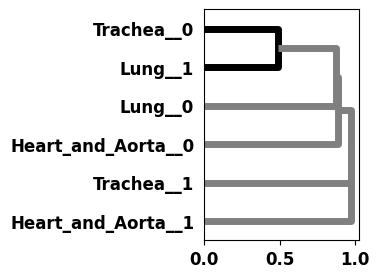

In [68]:
hierarchy.set_link_color_palette(['k', 'y'])

with rc_context({'lines.linewidth': 5}):


    plt.figure(figsize = (2,3))

    ax = dendrogram(linkage_data, orientation = 'right', labels = dists.columns,
                    above_threshold_color='grey')
    

    plt.xticks(size = 12,  weight = 'bold')
    plt.yticks(size = 12, weight = 'bold')


    plt.savefig('figures/3G.png', dpi = 600, bbox_inches = 'tight')
    plt.savefig('figures/3G.svg', bbox_inches = 'tight')

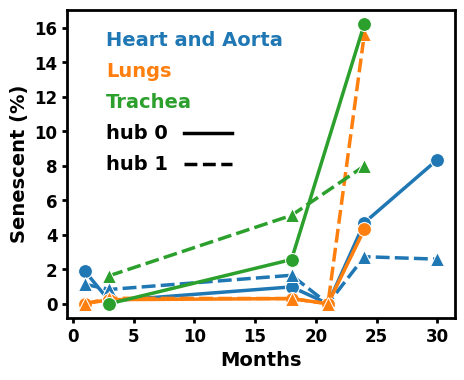

In [70]:
plt.figure(figsize = (5,4))


ax = sns.lineplot(data = df, x = 'age', y = 'per', hue = 'tissue',
                  style='hub', markersize = 10, markers = ['o', '^'], lw = 2.5)



for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescent (%)', size = 14, weight = 'bold')

plt.xlabel('Months', size = 14, weight = 'bold')

plt.legend([],[], frameon=False)

plt.text(s = 'Heart and Aorta', x = 0.1, y = 0.9, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:blue')

plt.text(s = 'Lungs', x = 0.1, y = 0.8, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:orange')

plt.text(s = 'Trachea', x = 0.1, y = 0.7, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:green')


plt.text(s = 'hub 0', x = 0.1, y = 0.6, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold')

plt.text(s = 'hub 1', x = 0.1, y = 0.5, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold')

plt.plot([.3, .425], [0.6, 0.6], transform = ax.transAxes, c = 'k', lw = 2.5)
plt.plot([.3, .425], [0.5, 0.5], transform = ax.transAxes, c = 'k', ls = '--', lw = 2.5)

plt.savefig('figures/3H.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3H.svg', bbox_inches = 'tight')

plt.show()

In [1]:

dfs_out = []

for hub in fibos:
    test = hubs[hub]
    test = [x[0] for x in test]
    
    
    enr = gp.enrichr(gene_list= test,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )
    
    
    res = enr.results
    res['tissue'] = hub[0]
    res['hub'] = hub[2]
    dfs_out.append(res)
    

In [72]:
fibo_go = pd.concat(dfs_out)

In [73]:
l = fibo_go[(fibo_go.tissue == 'Lung') & (fibo_go.hub == 1)]
l = l[l['Adjusted P-value'] < 0.05]

In [74]:
t = fibo_go[(fibo_go.tissue == 'Trachea') & (fibo_go.hub == 0)]
t = t[t['Adjusted P-value'] < 0.05]

### Fig 3I

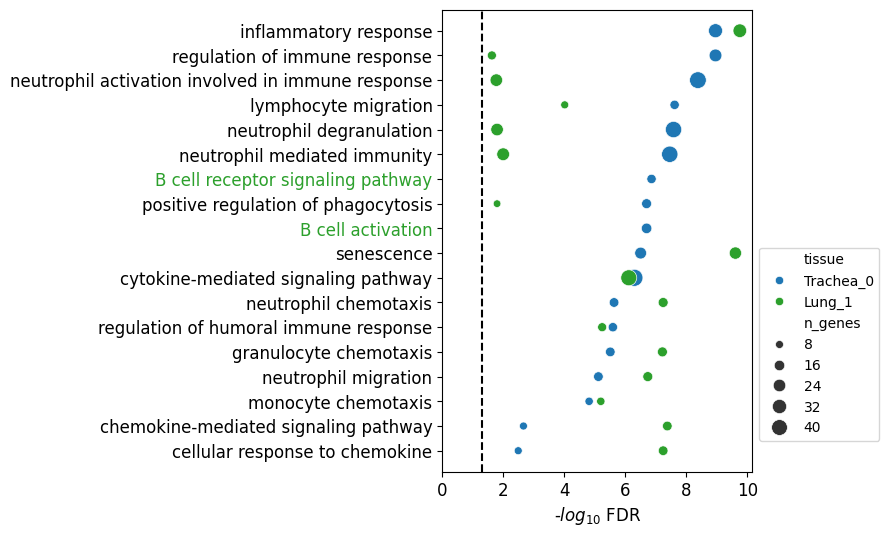

In [102]:
#get all terms in top 10 for both, include if in the other top 10
go10 = pd.concat((t,l))



go10 = go10[(go10.Gene_set.str.startswith('GO')) | (go10.Term == 'senescence')]

l_terms = go10[go10.tissue == 'Lung'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()
t_terms = go10[go10.tissue == 'Trachea'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()

go10_terms = l_terms + t_terms
go10_terms = list(set(go10_terms + ['senescence']))


go10 = go10[go10.Term.isin(go10_terms)]



go10.tissue = go10.tissue.map({'Trachea' : 'Trachea_0', 'Lung':'Lung_1'})


go10['nlog10'] = -np.log10(go10['Adjusted P-value'])
#go10['num'] = go10.Overlap.map(lambda x: int(x.split('/')[0]) )
go10['num'] = go10.Genes.map(lambda x: len(x.split(';')))
go10['Term_trim'] = go10.Term.map(lambda x: x.split(' (')[0])


go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])


go10 = go10.rename(columns = {'num': 'n_genes'})


plt.figure(figsize = (4,6))
ax = sns.scatterplot(data = go10, y = 'Term_trim', x = 'nlog10', hue = 'tissue', size = 'n_genes', sizes = (30,150),
                    palette = ['tab:blue', 'tab:green'])



plt.yticks(size = 12)

plt.xticks(size = 12)


plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')


yticklabels = [t for t in ax.get_yticklabels()]

for y, term in enumerate(go10.Term_trim.unique().tolist()): #SHOULD be in the same order as axis, but be careful
    if len(go10[go10.Term_trim == term]) < 2:
        if go10[go10.Term_trim == term].iloc[0].tissue == 'Trachea_0':
            yticklabels[y].set_color('tab:green')
        else:
            yticklabels[y].set_color('tab:orange')
        
    else:
        yticklabels[y].set_color('k')


plt.xlabel("-$log_{10}$ FDR", size = 12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))



plt.savefig('figures/3I.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3I.svg', bbox_inches = 'tight')


plt.show()



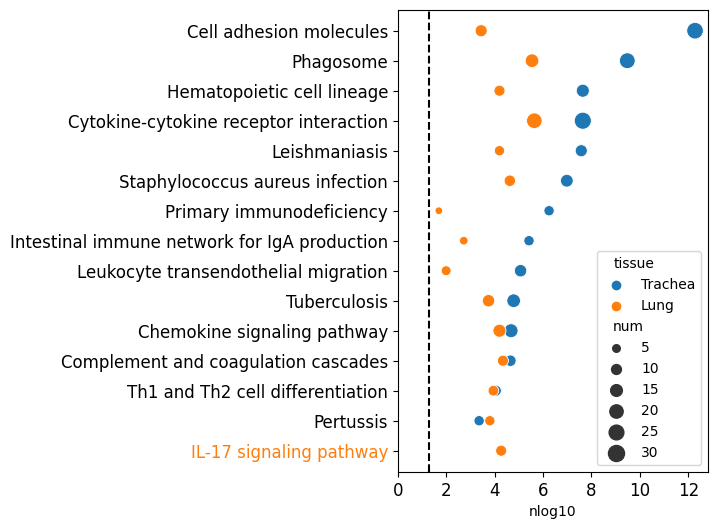

In [69]:
#get all terms in top 10 for both, include if in the other top 10
go10 = pd.concat((t,l))

go10 = go10[(go10.Gene_set.str.startswith('KEGG')) | (go10.Term == 'sensecence')]

l_terms = go10[go10.tissue == 'Lung'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()
t_terms = go10[go10.tissue == 'Trachea'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()

go10_terms = l_terms + t_terms
go10_terms = list(set(go10_terms))


go10 = go10[go10.Term.isin(go10_terms)]





go10['nlog10'] = -np.log10(go10['Adjusted P-value'])
go10['num'] = go10.Overlap.map(lambda x: int(x.split('/')[0]) )
go10['Term_trim'] = go10.Term.map(lambda x: x.split(' (')[0])


go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])

plt.figure(figsize = (4,6))
ax = sns.scatterplot(data = go10, y = 'Term_trim', x = 'nlog10', hue = 'tissue', size = 'num', sizes = (30,150))



plt.yticks(size = 12)

plt.xticks(size = 12)


plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')


yticklabels = [t for t in ax.get_yticklabels()]

for y, term in enumerate(go10.Term_trim.unique().tolist()): #SHOULD be in the same order as axis, but be careful
    if len(go10[go10.Term_trim == term]) < 2:
        if go10[go10.Term_trim == term].iloc[0].tissue == 'Trachea':
            yticklabels[y].set_color('tab:blue')
        else:
            yticklabels[y].set_color('tab:orange')
        
    else:
        yticklabels[y].set_color('k')


plt.show()


### Fig 3A

In [103]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import senepy as sp
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text


In [104]:
corr_path = '../data/files/tms_corr/'

corr_files = os.listdir('../data/files/tms_corr/')

corrs = pd.concat([pd.read_pickle(corr_path + x) for x in corr_files])
corrs['dif'] = corrs.r - corrs.rnd_r_q99
corrs_sig = corrs[(corrs.r > corrs.rnd_r_q99) & (corrs.r > 0) & (corrs.dif > 0.05)]

In [105]:
hubs = sp.load_hubs(species='Mouse')

In [106]:
a = [x[0] for x in hubs.hubs[('Tongue', 'keratinocyte', 0)]]
aa = dict(zip(a, ['tab:blue']*len(a)))

In [107]:
b = [x[0] for x in hubs.hubs[('Tongue', 'keratinocyte', 1)]]
bb = dict(zip(b, ['tab:orange']*len(b)))

In [108]:
cc = aa | bb

In [109]:
tester = corrs_sig[(corrs_sig.tissue == 'Tongue') & (corrs_sig.cell_type_2 == 'keratinocyte')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)

In [110]:
tester = tester[(tester.gene1.isin(a + b)) & (tester.gene2.isin(a + b))]

/tmp/ipykernel_1852208/4129994933.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


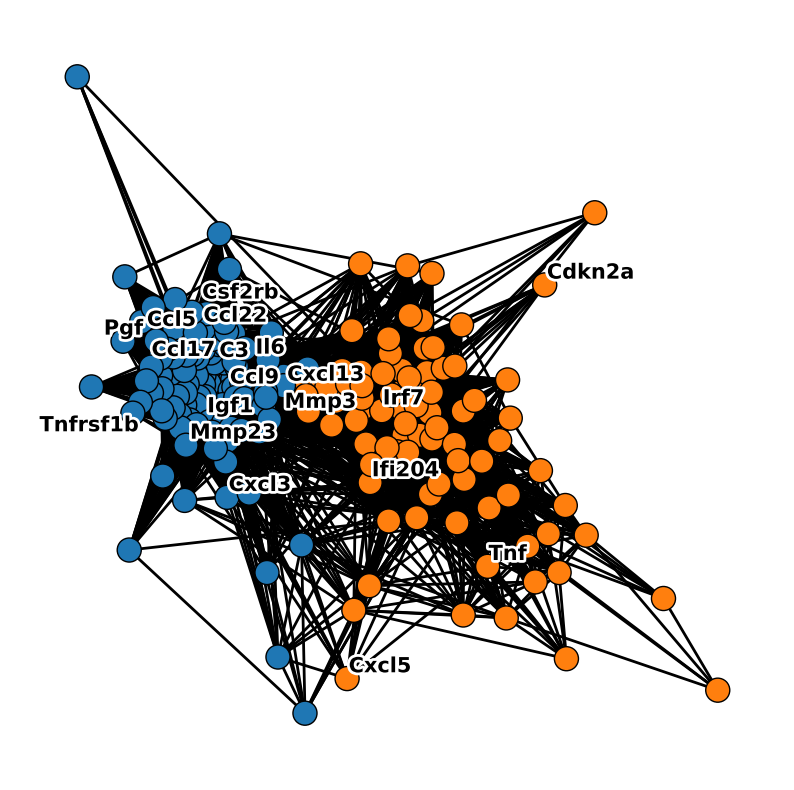

In [112]:
G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}


nx.draw_networkx_nodes(G, pos, 
                       node_color = [cc[node] for node in G.nodes()], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))



plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



plt.savefig('figures/3A.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/3A.svg', bbox_inches = 'tight')


plt.show()